In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', 100)

In [2]:
import sys
!{sys.executable} -m pip install dask 
!{sys.executable} -m pip install scikit-learn --upgrade

Requirement already up-to-date: scikit-learn in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages (0.23.2)


In [3]:
df = pd.read_csv('~/Desktop/maven_wave/Baker - Lending Club Data - DR_Demo_Lending_Club.csv',
                 index_col='Id',
                 parse_dates=['earliest_cr_line'],
                 dtype={'is_bad': bool})
print(df.shape)
df.sample()

(10000, 27)


,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,purpose,zip_code,addr_state,debt_to_income,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1960,False,Sierra Hills Apartments,2,RENT,38400.0,VERIFIED - income,n,Borrower added on 11/12/11 > I would like to pay my truck off and consolidate my bills for a low...,other,Wedding,936xx,CA,20.47,0.0,2000-07-01,1.0,46.0,109.0,7.0,1.0,3347,83.7,10.0,f,0.0,1,PC1


In [4]:
# Distribution of response variable
df.is_bad.value_counts(normalize=True)

False    0.8705
True     0.1295
Name: is_bad, dtype: float64

In [5]:
# Some featurization/data cleanup
df.loc[df.earliest_cr_line >= pd.to_datetime('2020-01-01'), 'earliest_cr_line'] = pd.NaT
df['earliest_cr_cohort'] = df.earliest_cr_line.dt.strftime('%Y')
df['pymnt_plan'] = df.pymnt_plan.map({'y': True, 'n': False})
df.dtypes.value_counts()

object            12
float64           11
bool               2
int64              2
datetime64[ns]     1
dtype: int64

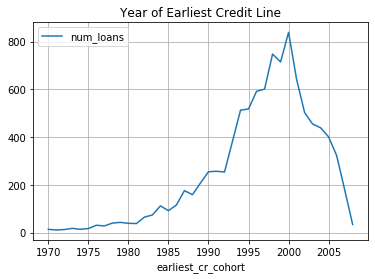

In [6]:
df.groupby('earliest_cr_cohort').size().plot(grid=True, label='num_loans')
plt.legend()
plt.title('Year of Earliest Credit Line');

In [7]:
df.isna().sum().sort_values(ascending=False)

mths_since_last_record         9160
mths_since_last_delinq         6316
Notes                          3230
emp_title                       592
earliest_cr_cohort               40
earliest_cr_line                 40
collections_12_mths_ex_med       32
revol_util                       26
inq_last_6mths                    5
delinq_2yrs                       5
open_acc                          5
total_acc                         5
pub_rec                           5
purpose                           4
annual_inc                        1
pymnt_plan                        0
mths_since_last_major_derog       0
emp_length                        0
home_ownership                    0
verification_status               0
purpose_cat                       0
initial_list_status               0
zip_code                          0
addr_state                        0
debt_to_income                    0
policy_code                       0
revol_bal                         0
is_bad                      

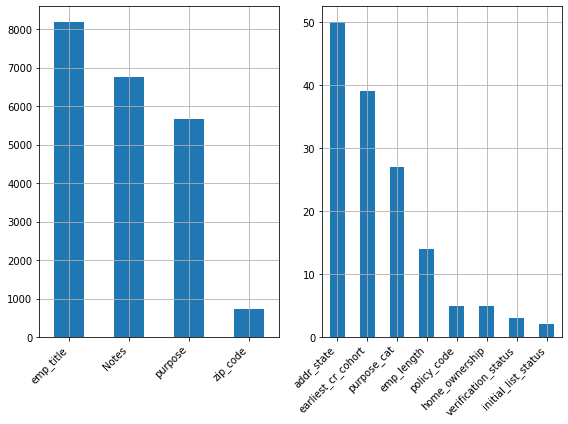

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
df.select_dtypes(include='object').nunique().sort_values(ascending=False).iloc[:4].plot(kind='bar', grid=True, ax=ax1)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

df.select_dtypes(include='object').nunique().sort_values(ascending=False).iloc[4:].plot(kind='bar', grid=True, ax=ax2)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.gcf().tight_layout()

In [9]:
obj_cols_to_use = df.select_dtypes(include='object').nunique().sort_values(ascending=False).iloc[3:].index.values.tolist()
print(obj_cols_to_use)

['zip_code', 'addr_state', 'earliest_cr_cohort', 'purpose_cat', 'emp_length', 'policy_code', 'home_ownership', 'verification_status', 'initial_list_status']


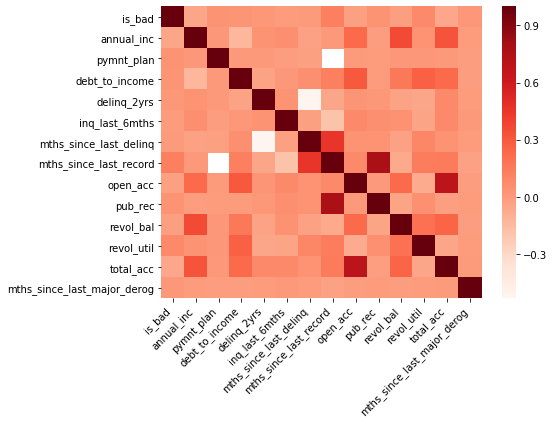

In [10]:
plt.figure(figsize=(8, 6))
corr = df.select_dtypes(include=[np.number, bool]).drop(columns=['collections_12_mths_ex_med']).corr()
sns.heatmap(corr, annot=False, cmap=plt.cm.Reds)
plt.xticks(rotation=45, ha='right')
plt.gcf().tight_layout()

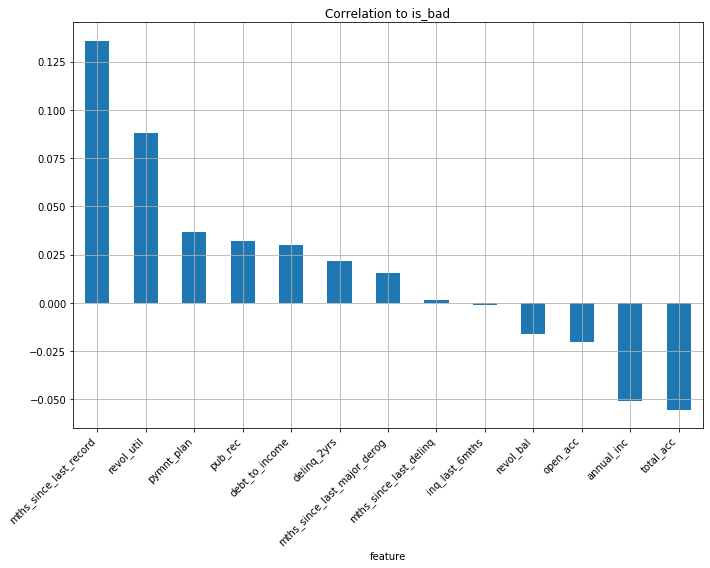

In [11]:
corr_2 = corr.unstack().to_frame('value').reset_index()
corr_2 = corr_2[corr_2.level_0 != corr_2.level_1]

tmp = corr_2[corr_2.level_0 == 'is_bad'].rename(columns={'level_1': 'feature'}).set_index('feature')[
    ['value']].sort_values('value', ascending=False)
tmp.plot(kind='bar', grid=True, legend=None, figsize=(10,8))
plt.title('Correlation to is_bad')
plt.xticks(rotation='45', ha='right')
plt.gcf().tight_layout()

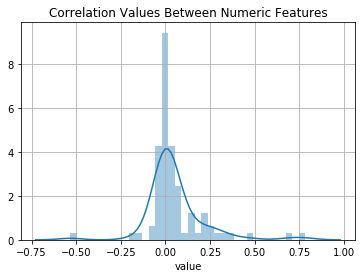

In [12]:
corr_2['features_set'] = corr_2.apply(lambda row: str(sorted([row.level_0, row.level_1])), axis=1)
corr_2 = corr_2.drop_duplicates(subset=['features_set']) \
    .drop(columns=['level_0', 'level_1']) \
    .sort_values('value', ascending=False).dropna()
sns.distplot(corr_2.value)
plt.title('Correlation Values Between Numeric Features')
plt.grid();

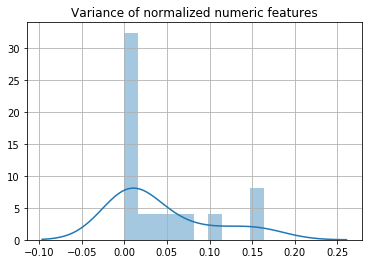

In [25]:
scaler = preprocessing.MinMaxScaler()
df_scale = pd.DataFrame(index=df.select_dtypes(include=[np.number, bool]).index,
                        data=scaler.fit_transform(df.select_dtypes(include=[np.number, bool])),
                        columns=df.select_dtypes(include=[np.number, bool]).columns)
sns.distplot(df_scale.var(), bins=10)
plt.title('Variance of normalized numeric features')
plt.grid()

In [26]:
# Remove features with very low variance
tmp_2 = (100 * df_scale.var().div(df_scale.var().max())).round(3).sort_values(ascending=False)
print(tmp_2)

mths_since_last_major_derog    100.000
mths_since_last_record          91.633
is_bad                          68.571
revol_util                      47.862
debt_to_income                  30.850
mths_since_last_delinq          21.120
total_acc                       10.528
open_acc                         8.630
pub_rec                          4.266
inq_last_6mths                   2.120
annual_inc                       1.781
delinq_2yrs                      1.288
revol_bal                        0.270
pymnt_plan                       0.122
collections_12_mths_ex_med       0.000
dtype: float64


In [27]:
num_cols_to_use = tmp_2[tmp_2 >= 0].index.values.tolist()
print(num_cols_to_use)

['mths_since_last_major_derog', 'mths_since_last_record', 'is_bad', 'revol_util', 'debt_to_income', 'mths_since_last_delinq', 'total_acc', 'open_acc', 'pub_rec', 'inq_last_6mths', 'annual_inc', 'delinq_2yrs', 'revol_bal', 'pymnt_plan', 'collections_12_mths_ex_med']


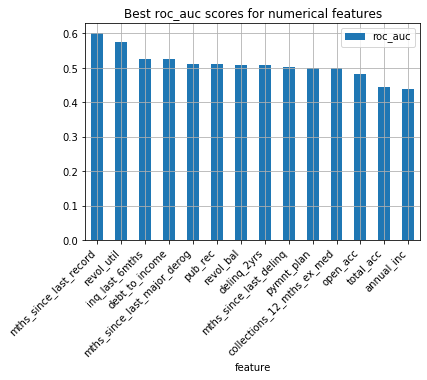

In [28]:
# Compute roc_auc score using numeric features
from sklearn.metrics import roc_auc_score
tmp_df = df[num_cols_to_use].copy()
tmp_df.drop(columns=['is_bad'], inplace=True)
l = []
# tmp_df.apply(lambda col: roc_auc_score(df.is_bad, col))
for col in tmp_df.iteritems():
    new_df = pd.DataFrame(data={'feature': col[1]})
    new_df['label'] = df['is_bad']
    new_df = new_df.dropna()
    val = roc_auc_score(new_df.label, new_df.feature)
    d = {'feature': col[0], 'roc_auc': val}
    l.append(d)
tmp_df_2 = pd.DataFrame(l).sort_values('roc_auc', ascending=False).set_index('feature')
tmp_df_2.plot(kind='bar', grid=True)
plt.xticks(rotation=45, ha='right')
plt.title('Best roc_auc scores for numerical features');

In [141]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.datasets import load_iris
# from sklearn.feature_selection import SelectFromModel

In [29]:
cols = sorted(obj_cols_to_use + num_cols_to_use)
print(cols)

['addr_state', 'annual_inc', 'collections_12_mths_ex_med', 'debt_to_income', 'delinq_2yrs', 'earliest_cr_cohort', 'emp_length', 'home_ownership', 'initial_list_status', 'inq_last_6mths', 'is_bad', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'open_acc', 'policy_code', 'pub_rec', 'purpose_cat', 'pymnt_plan', 'revol_bal', 'revol_util', 'total_acc', 'verification_status', 'zip_code']


In [30]:
df_1 = df[cols].copy()
df_2 = pd.get_dummies(df_1)
df_2.shape

(10000, 880)

In [31]:
varr = df_2.var().sort_values()
varr = varr[varr >= 0.01]
varr.shape

(102,)

In [99]:
df_2.isna().sum()[df_2.isna().sum() > 0].sort_values(ascending=False)

mths_since_last_record        9160
mths_since_last_delinq        6316
collections_12_mths_ex_med      32
revol_util                      26
total_acc                        5
pub_rec                          5
open_acc                         5
inq_last_6mths                   5
delinq_2yrs                      5
annual_inc                       1
dtype: int64

In [107]:
from sklearn.impute import SimpleImputer
df_3 = pd.DataFrame(index=df_2.set_index('is_bad').index, 
                    columns=df_2.set_index('is_bad').columns,
                    data = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df_2.set_index('is_bad')))
df_3.reset_index(inplace=True)

In [108]:
X = df_3[varr.index.values.tolist()].copy().drop(columns=['is_bad'])
y = df_3[['is_bad']].copy()

In [109]:
# Split into test and train and make sure evenly sampled data
X_train, X_test, y_train, y_test = train_test_split(X, y) 
print(f'y_train value counts = {y_train.is_bad.value_counts(normalize=True).loc[True]:0.2f}')
print(f'y_test value counts = {y_test.is_bad.value_counts(normalize=True).loc[True]:0.2f}')

y_train value counts = 0.13
y_test value counts = 0.12


In [110]:
# clf = GaussianNB()
clf =  LogisticRegression()
clf.fit(X_train, y_train.values.flatten())
preds = y_test.copy()
preds['y_prob_lr'] = clf.predict_proba(X_test)[:, 1]

In [111]:
# Print roc_auc score
print(f'roc auc score with LogisticRegression = {roc_auc_score(preds.is_bad, preds.y_prob_lr)}')

roc auc score with LogisticRegression = 0.5633957569196464


In [112]:
# Try logistic regression
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train.values.flatten())
preds['y_prob_rf'] = clf.predict_proba(X_test)[:, 1]

In [113]:
# Print roc_auc score
print(f'roc auc score with RandomForest = {roc_auc_score(preds.is_bad, preds.y_prob_rf)}')

roc auc score with RandomForest = 0.6779578982312909


In [114]:
# Use Grid search to find best XGBoost parameters with stochastic column sampling using roc_auc for scoring
param_grid = {
    'n_estimators': [50, 100], 
    'max_depth': [5, 9], 
    'learning_rate': [0.01, 0.1, 0.25], 
    'colsample_bytree': [0.5, 1.0]
}
b = y_train.is_bad.value_counts()
scale_pos_weight = b.loc[False] / b.loc[True]
xgb_grid_clf = GridSearchCV(XGBClassifier(scale_pos_weight=scale_pos_weight),
                            param_grid,
                            cv=3,
                            verbose=10, 
                            scoring='roc_auc', 
                            n_jobs=-1)
xgb_grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.5min finished
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=6.621951219512195,
                                     subsample=None, tree

In [117]:
model = xgb_grid_clf.best_estimator_ 
params = xgb_grid_clf.best_params_ 
scores = xgb_grid_clf.cv_results_
print(f'best params found: {params}')

best params found: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


In [118]:
y_test = y_test.copy()

In [119]:
# Print classification report
y_test['y_pred'] = model.predict(X_test) 
y_test['y_prob'] = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test.is_bad, y_test.y_pred))

              precision    recall  f1-score   support

       False       0.91      0.76      0.83      2189
        True       0.23      0.49      0.31       311

    accuracy                           0.73      2500
   macro avg       0.57      0.62      0.57      2500
weighted avg       0.83      0.73      0.77      2500



In [120]:
# Print roc_auc score
print(f'roc auc score on test data = {roc_auc_score(y_test.is_bad, y_test.y_prob)}')

roc auc score on test data = 0.6729687607872745


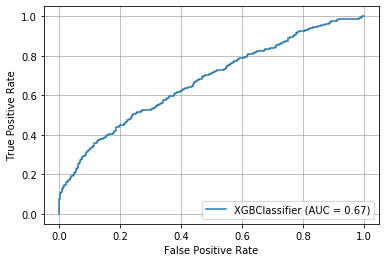

In [121]:
plot_roc_curve(model, X_test, y_test.is_bad)
plt.grid()

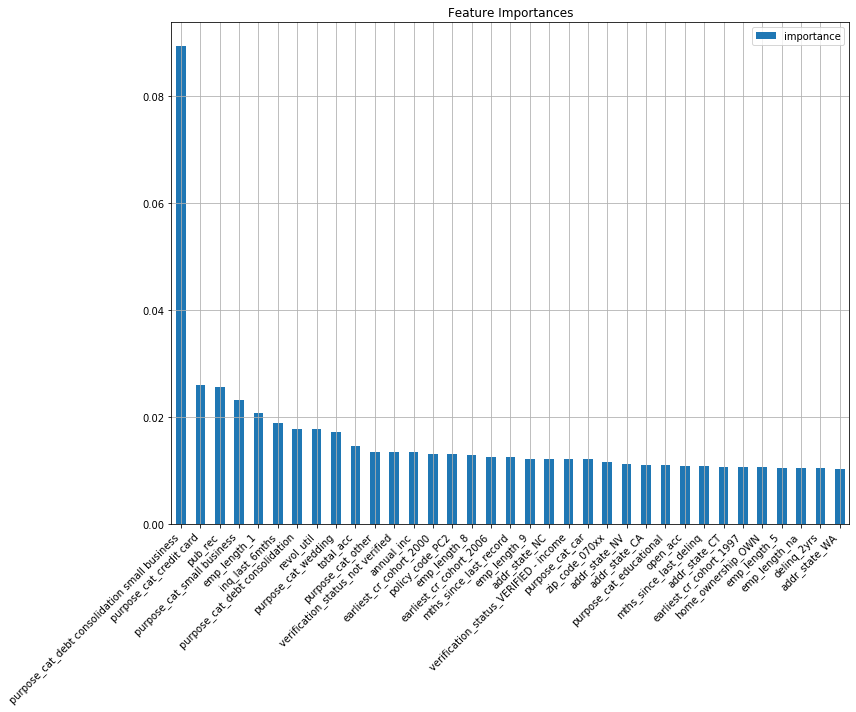

In [122]:
# Plot feature importances
tmp = pd.DataFrame(index=X_test.columns, 
                   data={'importance': model.feature_importances_}).sort_values('importance', ascending=False) 
# tmp[tmp.importance > 0].plot(kind='bar', grid=True, figsize=(12,10)) 
tmp.head(35).plot(kind='bar', grid=True, figsize=(12,10)) 
plt.xticks(rotation=45, ha='right');
plt.title('Feature Importances'); plt.gcf().tight_layout();

In [123]:
# tmp.loc[num_cols_to_use].head(35).plot(kind='bar', grid=True, figsize=(12,10)) 
# plt.xticks(rotation=45, ha='right');
# plt.title('Feature Importances'); 
# plt.gcf().tight_layout();

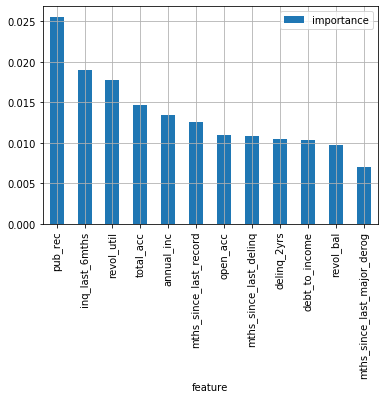

In [124]:
tmp_2 = tmp.reset_index().rename(columns={'index': 'feature'})
tmp_3 = tmp_2[tmp_2.feature.isin(num_cols_to_use)].set_index('feature')
tmp_3.plot(kind='bar', grid=True);

In [125]:
cat = tmp.iloc[0].name
res = df_2[[cat, 'is_bad']]
res.corr()

,purpose_cat_debt consolidation small business,is_bad
purpose_cat_debt consolidation small business,1.000000,0.263194
is_bad,0.263194,1.000000


In [126]:
cat = tmp.iloc[1].name
res = df_2[[cat, 'is_bad']]
res.corr()

,purpose_cat_credit card,is_bad
purpose_cat_credit card,1.000000,-0.055271
is_bad,-0.055271,1.000000


In [127]:
cat = tmp.iloc[2].name
res = df_2[[cat, 'is_bad']]
res.corr()

,pub_rec,is_bad
pub_rec,1.000000,0.032174
is_bad,0.032174,1.000000


In [128]:
for i in range(tmp.shape[0]):
    cat = tmp.iloc[i].name
    res = df_2[[cat, 'is_bad']]
    print(f'{cat}:{res.corr().iloc[0].is_bad}')

purpose_cat_debt consolidation small business:0.2631939273752994
purpose_cat_credit card:-0.05527112668172508
pub_rec:0.03217396763656981
purpose_cat_small business:0.07996337071993606
emp_length_1:0.019253509096275833
inq_last_6mths:-0.0011462653346675184
purpose_cat_debt consolidation:-0.03283528335806815
revol_util:0.08787567952383696
purpose_cat_wedding:-0.035053853205060485
total_acc:-0.055307034351278095
purpose_cat_other:-0.007721882079489712
verification_status_not verified:-0.05015838447534834
annual_inc:-0.05097499797039757
earliest_cr_cohort_2000:0.00789561748847199
policy_code_PC2:0.02319053438906026
emp_length_8:-0.02015636961639124
earliest_cr_cohort_2006:0.0053428602174874365
mths_since_last_record:0.1357349982943765
emp_length_9:-0.014758091390378968
addr_state_NC:0.01700962597915765
verification_status_VERIFIED - income:0.04323119876026347
purpose_cat_car:-0.02628307759426754
zip_code_070xx:-0.003183396890355476
addr_state_NV:0.03433151426768444
addr_state_CA:0.0271602

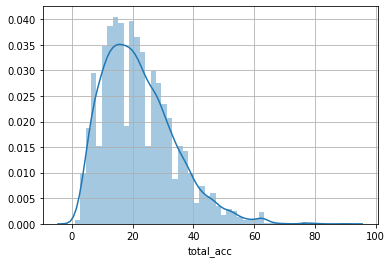

In [129]:
sns.distplot(df_2.total_acc.dropna());
plt.grid();

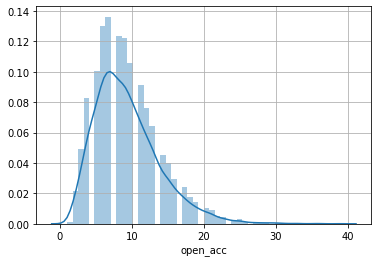

In [130]:
sns.distplot(df_2.open_acc.dropna());
plt.grid();

In [131]:
from sklearn.preprocessing import KBinsDiscretizer